In [1]:
#%matplotlib notebook
%matplotlib inline
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy import stats
import os, sys, re
display(HTML("<style>.container { width:100% !important; }</style>"))
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "all"

In [2]:
settings = {
    'path': '/mnt/DATA/ML/experiments/FINAL/relatedness.tsv',
    #'metrics_task': ['pearson_r'],
    'metrics': ['test_pearson_r', 'time_s'],
    #'metric_dev': 'dev_best_pearson_r',
    'parameters': ['data', 'te'] # entries from run_desc
}
#path = '/mnt/DATA/ML/experiments/FINAL/relatedness.tsv'
#metrics_task = ['pearson_r']
path = settings['path']
#metrics_task = settings['metrics_task']
metrics = settings['metrics']
parameters = settings['parameters']
df_loaded = pd.read_table(path)

In [3]:
pd.set_option('display.max_columns', None)
df_loaded.head()
#df['run_desc']

,dev_best_mse,dev_best_pearson_r,dev_file_indices,dir,run_desc,run_description,steps_train,test_mse,test_pearson_r,time_s
0,0.022706,0.855711,NaN,RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cn...,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cn...,1116,0.023757,0.846748,170.254336
1,0.025306,0.840537,NaN,RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cn...,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cn...,720,0.025217,0.838855,131.047285
2,0.024927,0.849637,NaN,RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cn...,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cn...,864,0.024954,0.845191,145.982807
3,0.024083,0.850401,NaN,RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cn...,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cn...,1044,0.024594,0.844804,164.700356
4,0.024111,0.849922,NaN,RECNN,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cn...,a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cn...,648,0.024482,0.844788,126.079993


In [19]:
COLUMN_RUN = 'run'
COLUMN_RUN_DESC_COLS = 'run_desc_cols'
COLUMN_DFIDX = 'dfidx'
COLUMN_RUN_DESC_NEW = 'run_desc'

map_value_short = {'CORENLPNONERRECEMBEDGESMC2': 'E', 
             'CORENLPNONERRECEMBMC2': 'D',
             'HTUREDUCEMAXMAPGRU': 'MAX-GRU',
             'HTUREDUCESUMMAPGRU': 'SUM-GRU',
             'FLATGRU': 'GRU',
             'FLATSUM': 'SUM',
             'FLATMAX': 'MAX',
            }
map_value_long = {'E': 'edges', 'D': 'direct'}
map_param_short = {'data': 'l', 'te': 'm'}
map_param_long = {'l': 'linking', 'm': 'model'}
metrics_inverted = ['time_s', 'steps_train']
parameters = [map_param_short.get(p, p) for p in parameters]

def run_desc_to_dict(run_desc):
    _res = {}
    parts = run_desc.split('/')
    if len(parts) == 2:
        _res[COLUMN_RUN] = parts[1]
    elif len(parts) > 2:
        print('WARNINING: more then 2 parts for split with "/": %s' % run_desc)
    else:
        print('WARNINING: no split_idx found: %s' % run_desc)
    run_desc = parts[0]
    parts = re.split(r'(_|^)([a-z]+)', run_desc)
    #new_entries = {parts[i-1]: ','.join(parts[i].strip().split('-')) for i in range(3, len(parts), 3)}
    new_entries = {map_param_short.get(parts[i-1], parts[i-1]): map_value_short.get(parts[i], parts[i]) for i in range(3, len(parts), 3)}
    _res.update(new_entries)
    cols_run_desc = sorted([k for k in new_entries if k not in [COLUMN_RUN, COLUMN_DFIDX]])
    #_res[COLUMN_RUN_DESC_COLS] = ','.join()
    _res[COLUMN_RUN_DESC_NEW] = '_'.join([col + _res[col] for col in cols_run_desc])
    return _res

#run_desc_to_dict('a_avfF_bs100_dF_bPOS-NIFW-PAR_clp5.0_cmTREE_cntxt0_dfidx0-1_dtF_fc_kp0.9_kpb1.0_kpn1.0_leaffc0_lr0.001_lc-1_dpth20_mtSIMTUPLE_n10000_ns20_nfvF_rootfc300_sm_sl50_st150_tk_dataCORENLPNONERRECEMBEDGESMC2_teHTUREDUCESUMMAPGRU_ccF_tfidfF_vvrF_vvzF/0')
#pd.DataFrame(df['run_description'].apply(run_desc_to_dict))#, axis=1, result_type='expand')
df_runddesc = pd.DataFrame([run_desc_to_dict(rd) for rd in df_loaded['run_description']])
#metrics_test = ['test_' + m for m in metrics_task]
#metrics_dev_best = ['dev_best_' + m for m in metrics_task]
#metrics_performance = metrics_dev_best + metrics_test
#metrics_resources = ['steps_train', 'time_s'] 
#metrics_all = metrics_performance + metrics_resources
take_columns = metrics + ['dir']
df_all = pd.concat([df_loaded[take_columns], df_runddesc], axis=1)

if 'metric_dev' in settings:
    print('keep only runs with max %s ...' % settings['metric_dev'])
    df_all = df_all.sort_values(settings['metric_dev'], ascending=False).drop_duplicates(['run_desc', 'run'])

df_all#.describe()

,test_pearson_r,time_s,dir,a,avf,b,bs,cc,clp,cm,cntxt,d,dfidx,dpth,dt,ec,fc,kp,kpb,kpn,l,lc,leaffc,lr,m,mt,n,nfv,ns,rootfc,run,run_desc,sl,sm,st,tfidf,tk,vvr,vvz
0,0.846748,170.254336,RECNN,,F,POS-NIFW-PAR,100,F,5.0,TREE,0,F,0-1,20,F,NaN,,0.9,1.0,1.0,E,-1,0,0.001,SUM-GRU,SIMTUPLE,10000,F,20,300,0,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_c...,50,,150,F,,F,F
1,0.838855,131.047285,RECNN,,F,POS-NIFW-PAR,100,F,5.0,TREE,0,F,0-1,20,F,NaN,,0.9,1.0,1.0,E,-1,0,0.001,SUM-GRU,SIMTUPLE,10000,F,20,300,1,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_c...,50,,150,F,,F,F
2,0.845191,145.982807,RECNN,,F,POS-NIFW-PAR,100,F,5.0,TREE,0,F,0-1,20,F,NaN,,0.9,1.0,1.0,E,-1,0,0.001,SUM-GRU,SIMTUPLE,10000,F,20,300,2,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_c...,50,,150,F,,F,F
3,0.844804,164.700356,RECNN,,F,POS-NIFW-PAR,100,F,5.0,TREE,0,F,0-1,20,F,NaN,,0.9,1.0,1.0,E,-1,0,0.001,SUM-GRU,SIMTUPLE,10000,F,20,300,3,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_c...,50,,150,F,,F,F
4,0.844788,126.079993,RECNN,,F,POS-NIFW-PAR,100,F,5.0,TREE,0,F,0-1,20,F,NaN,,0.9,1.0,1.0,E,-1,0,0.001,SUM-GRU,SIMTUPLE,10000,F,20,300,4,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_c...,50,,150,F,,F,F
5,0.834215,119.910152,RECNN,,F,POS-NIFW-PAR,100,F,5.0,TREE,0,F,2-3,20,F,NaN,,0.9,1.0,1.0,E,-1,0,0.001,SUM-GRU,SIMTUPLE,10000,F,20,300,0,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_c...,50,,150,F,,F,F
6,0.840178,137.524955,RECNN,,F,POS-NIFW-PAR,100,F,5.0,TREE,0,F,2-3,20,F,NaN,,0.9,1.0,1.0,E,-1,0,0.001,SUM-GRU,SIMTUPLE,10000,F,20,300,1,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_c...,50,,150,F,,F,F
7,0.843177,189.146452,RECNN,,F,POS-NIFW-PAR,100,F,5.0,TREE,0,F,2-3,20,F,NaN,,0.9,1.0,1.0,E,-1,0,0.001,SUM-GRU,SIMTUPLE,10000,F,20,300,2,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_c...,50,,150,F,,F,F
8,0.844995,131.137732,RECNN,,F,POS-NIFW-PAR,100,F,5.0,TREE,0,F,2-3,20,F,NaN,,0.9,1.0,1.0,E,-1,0,0.001,SUM-GRU,SIMTUPLE,10000,F,20,300,3,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_c...,50,,150,F,,F,F
9,0.844256,145.281179,RECNN,,F,POS-NIFW-PAR,100,F,5.0,TREE,0,F,2-3,20,F,NaN,,0.9,1.0,1.0,E,-1,0,0.001,SUM-GRU,SIMTUPLE,10000,F,20,300,4,a_avfF_bPOS-NIFW-PAR_bs100_ccF_clp5.0_cmTREE_c...,50,,150,F,,F,F


In [5]:
#cols_group = ['l', 'm']
#df_all[metrics_all + cols_group].groupby(cols_group).mean()
res = df_all[metrics + parameters + [COLUMN_RUN, COLUMN_DFIDX]].set_index(parameters)
res[:100]

test_pearson_r      time_s run dfidx
l m                                            
E SUM-GRU        0.846748  170.254336   0   0-1
  SUM-GRU        0.838855  131.047285   1   0-1
  SUM-GRU        0.845191  145.982807   2   0-1
  SUM-GRU        0.844804  164.700356   3   0-1
  SUM-GRU        0.844788  126.079993   4   0-1
  SUM-GRU        0.834215  119.910152   0   2-3
  SUM-GRU        0.840178  137.524955   1   2-3
  SUM-GRU        0.843177  189.146452   2   2-3
  SUM-GRU        0.844995  131.137732   3   2-3
  SUM-GRU        0.844256  145.281179   4   2-3
  SUM-GRU        0.844203  231.275493   0   4-5
  SUM-GRU        0.850174  132.637942   1   4-5
  SUM-GRU        0.845249  153.493553   2   4-5
  SUM-GRU        0.843701  104.231680   3   4-5
  SUM-GRU        0.850759  209.386398   4   4-5
  SUM-GRU        0.842012  133.411548   0   6-7
  SUM-GRU        0.841688  175.912167   1   6-7
  SUM-GRU        0.841937  154.833019   2   6-7
  SUM-GRU        0.844720  147.493940   3   6-7
  SUM-GRU        0.840702  182.264224   4   6-7
  SUM-GRU        0.841744  107.947581   0   8-9
  SUM-GRU        0.842573   93.288441   1   8-9
  SUM-GRU        0.852119  251.700443   2   8-9
  SUM-GRU        0.848616  193.141271   3   8-9
  SUM-GRU        0.848677  156.227264   4   8-9
  MAX-GRU        0.843924  177.084965   0   0-1
  MAX-GRU        0.850571  223.085611   1   0-1
  MAX-GRU        0.845004  220.891055   2   0-1
  MAX-GRU        0.845707  172.274830   3   0-1
  MAX-GRU        0.846124  224.510654   4   0-1
...                   ...         ...  ..   ...
D SUM-GRU        0.848027  121.666413   0   8-9
  SUM-GRU        0.843643  123.210310   1   8-9
  SUM-GRU        0.848634  161.316481   2   8-9
  SUM-GRU        0.842092  101.400905   3   8-9
  SUM-GRU        0.839317  109.127969   4   8-9
  MAX-GRU        0.850152  119.776147   0   0-1
  MAX-GRU        0.847101  118.826732   1   0-1
  MAX-GRU        0.848184  123.442762   2   0-1
  MAX-GRU        0.850047  218.836279   3   0-1
  MAX-GRU        0.849223  137.343183   4   0-1
  MAX-GRU        0.845812   96.941143   0   2-3
  MAX-GRU        0.839515  107.413579   1   2-3
  MAX-GRU        0.846468  134.862066   2   2-3
  MAX-GRU        0.844742  139.933710   3   2-3
  MAX-GRU        0.839331  108.859016   4   2-3
  MAX-GRU        0.848908  216.827989   0   4-5
  MAX-GRU        0.848704  111.425631   1   4-5
  MAX-GRU        0.855640  141.238984   2   4-5
  MAX-GRU        0.852177  149.219247   3   4-5
  MAX-GRU        0.853131  154.245347   4   4-5
  MAX-GRU        0.849092  159.935697   0   6-7
  MAX-GRU        0.844497  196.871762   1   6-7
  MAX-GRU        0.839914  179.625705   2   6-7
  MAX-GRU        0.847566  147.846484   3   6-7
  MAX-GRU        0.845817  220.389930   4   6-7
  MAX-GRU        0.851610  152.148783   0   8-9
  MAX-GRU        0.848781  166.196504   1   8-9
  MAX-GRU        0.851540  144.893684   2   8-9
  MAX-GRU        0.854002  140.590976   3   8-9
  MAX-GRU        0.853143  153.040098   4   8-9

[100 rows x 4 columns]

In [6]:
from sklearn.utils import resample
def bootstrap_5th_percentile(data, n_bootstraps):
    bootstraps = []
    for _ in xrange(n_bootstraps):
        # Sample with replacement from data
        samples = resample(data)
        # Then we take the fifth percentile!
        bootstraps.append(np.percentile(samples, len(data) * 0.1))
    return pd.Series(bootstraps)
#values = res.xs(('NO', 'NO'))['pearson']
#bootstraps = bootstrap_5th_percentile(values, 10000)
#bootstraps.hist()

In [7]:
#df_all.boxplot(by=parameters, column=metrics_performance, figsize=(40,20), notch=True)

In [8]:
#for m in metrics_resources:
#    df_all.boxplot(by=parameters, column=m, figsize=(10,5))

In [9]:
res.groupby(parameters).mean()

test_pearson_r      time_s
l m                                  
D GRU            0.840231  167.926990
  MAX            0.844985   82.983544
  MAX-GRU        0.848204  149.629258
  SUM            0.847378   97.660764
  SUM-GRU        0.847671  151.754026
E MAX-GRU        0.842520  191.659030
  SUM-GRU        0.844243  155.532408

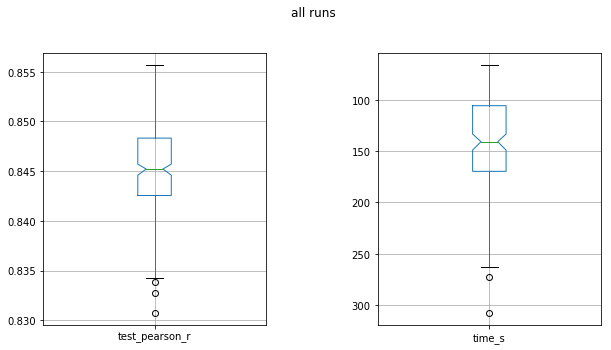

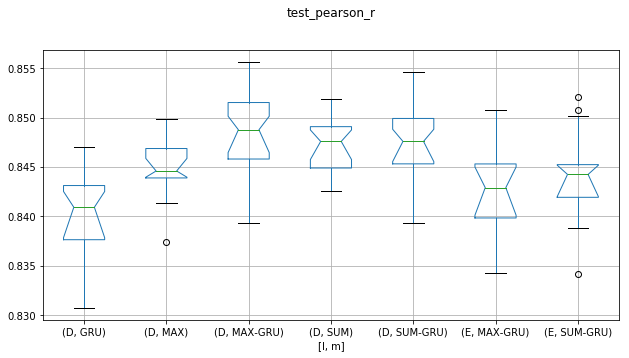

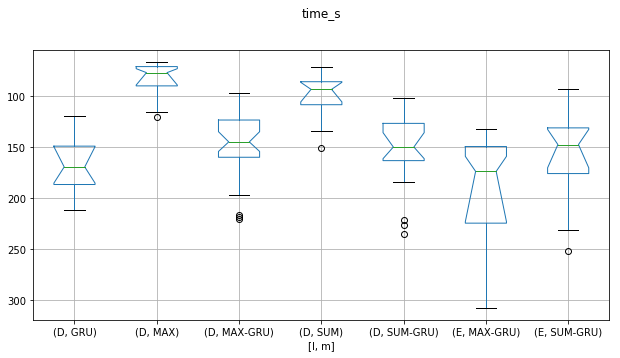

In [22]:
from matplotlib import rcParams
# final
#figsize = (4.5, 3)
# debug
figsize = (10, 5)


current_metrics = metrics
current_parameters = parameters[:2]
# use short versions
current_values = {'l': ['D', 'E'], 'm': ['SUM', 'MAX', 'GRU', 'SUM-GRU', 'MAX-GRU']}

#rcParams['axes.titlepad'] = 20 
#rcParams['axes.titlepad'] = 20 
images = {}
bootstrap=10000
#rcParams.update({'figure.autolayout': True})

fig_merged, axs = plt.subplots(1, len(current_metrics), figsize=figsize)
for i, m in enumerate(current_metrics):
    res.boxplot(column=m, figsize=(figsize[i] / len(current_metrics), figsize[1]), ax=axs[i], bootstrap=bootstrap, notch=True)
    if m in metrics_inverted:
        axs[i].invert_yaxis()
    
#axs[0].invert_yaxis()
#axs[0].minorticks_on()
#axs[0].grid(which='minor', linestyle=':', linewidth='0.3', color='black')
#res.boxplot(column='test_pearson_r', figsize=(figsize[0] / 2, figsize[1]), ax=axs[1], bootstrap=bootstrap, notch=True)
#axs[1].minorticks_on()
#axs[1].grid(which='minor', linestyle=':', linewidth='0.3', color='black')
fig_merged.suptitle('all runs', y=1.01)
plt.subplots_adjust(wspace=0.5)
images['fig_merged'] = fig_merged

y_title = 1.0
y_suptitle = 1.1

#levels = ['order aware', 'dependency available']
#other_level = {levels[0]: levels[1], levels[1]: levels[0]}
other_parameter = {current_parameters[0]: current_parameters[1], current_parameters[1]:current_parameters[0]}

def param_long(param):
    #return ''.join([w[0].upper() for w in param.split()])
    return map_param_long.get(param, param)

for m in current_metrics:
    axs = res.boxplot(column=m, by=current_parameters, figsize=figsize, bootstrap=bootstrap, notch=True)
    if m in metrics_inverted:
        axs.invert_yaxis()
    #axs.minorticks_on()
    #axs.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
    plt.title(m, y=y_suptitle)
    fig_sep = axs.get_figure()
    fig_sep.suptitle('')
    images['fig_sep_'+m] = fig_sep




test_pearson_r
time_s


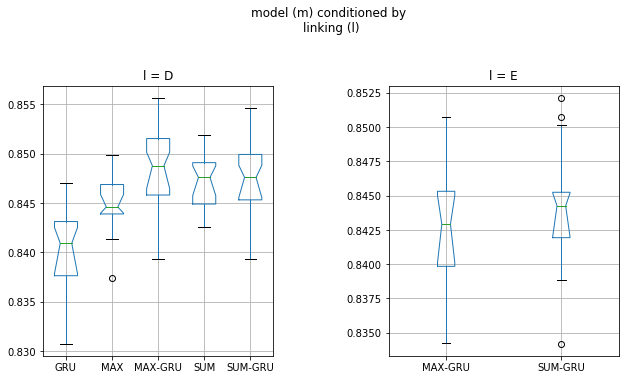

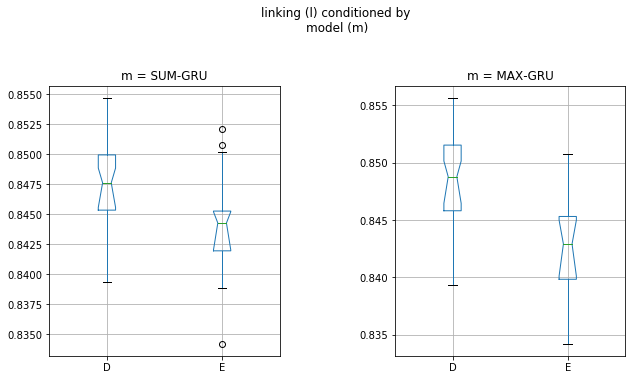

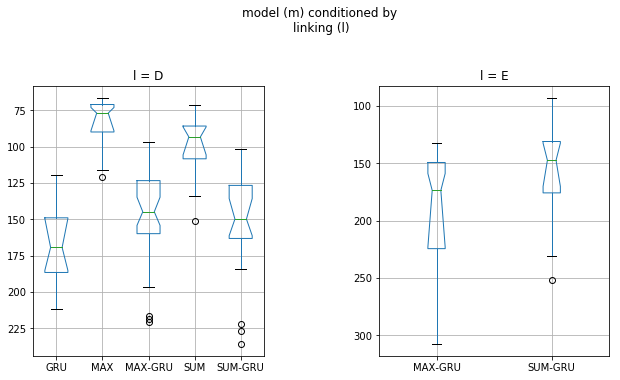

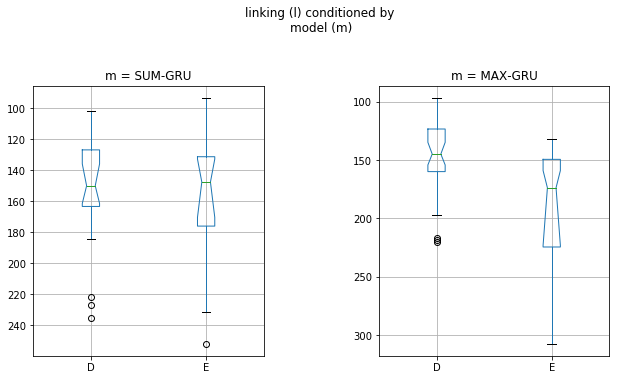

In [20]:
for m in current_metrics:
    print(m)
    for parameter in current_parameters:
        values = current_values[parameter]
        # collect values where other parameters has more then one values
        values_selected = []
        for i, v in enumerate(values):
            other_values = set(res.xs(v, level=parameter).index.values)
            if len(other_values) > 1:
                values_selected.append(v)
        
        fig_sep, axs_sep = plt.subplots(1,len(values_selected), figsize=figsize)
        for i, v in enumerate(values_selected):

            #res.xs(v, level=parameter).boxplot(column=['pearson'], by=[other_parameter[parameter]], ax=axs_sep[0], bootstrap=bootstrap, notch=True)
            #axs_sep[0].set_title('pearson', y=y_title)
            #axs_sep[0].set_xlabel('')
            #print(res.xs(v, level=parameter)[m].groupby([other_parameter[parameter]]).count())
            other_values = set(res.xs(v, level=parameter).index.values)
            if len(other_values) == 1:
                continue
            res.xs(v, level=parameter).boxplot(column=[m], by=[other_parameter[parameter]], ax=axs_sep[i], bootstrap=bootstrap, notch=True)
            axs_sep[i].set_title('%s = %s' % (parameter, v), y=y_title)
            axs_sep[i].set_xlabel('')
            if m in metrics_inverted:
                axs_sep[i].invert_yaxis()
        fig_sep.suptitle('%s (%s) conditioned by \n%s (%s)' % (param_long(other_parameter[parameter]), other_parameter[parameter], param_long(parameter), parameter), y=y_suptitle + 0.02)
        #fig_sep.suptitle('%s (%s) conditioned by \n%s (%s)' % (other_parameter[parameter], other_parameter[parameter], parameter, parameter), y=y_suptitle + 0.02)
        #plt.subplots_adjust(left=0.2, wspace=0.8, top=0.8)
        plt.subplots_adjust(wspace=0.5)
        images['fig_sep_cond_%s' % other_parameter[parameter].split()[0]] = fig_sep


In [12]:
import numpy
from pandas import read_csv
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib import pyplot
from math import sqrt
import scipy.stats as st

def bootstrap_convidence(values, n_iterations=1000, alpha=0.95):
    #values = res.xs(('NO', 'NO'))['pearson']
    mean_b = np.mean(values)
    std_b = np.std(values)
    n_b_root = sqrt(len(values))
    # configure bootstrap
    #n_iterations = 10000
    n_size = int(len(values) * 0.10)
    # run bootstrap
    stats = list()
    for i in range(n_iterations):
        samples = resample(values, n_samples=n_size)
        t_i = (np.mean(samples) - mean_b) * n_b_root / np.std(samples)
        stats.append(t_i)
    # plot scores
    #pyplot.hist(stats)
    #pyplot.show()
    
    # confidence intervals
    #print(stats)
    #p_lower = ((1.0-alpha)/2.0) * 100
    p_lower = (alpha/2.) * 100
    #p = (alpha / 2.0) * 100
    lower = numpy.percentile(stats, p_lower)
    #lower = st.t._ppf(p_lower, n_iterations-1)
    #print('lower %.2f: %.3f' % (p_lower, lower))
    #p_upper = (alpha+((1.0-alpha)/2.0)) * 100
    p_upper = (1.-alpha/2.) * 100
    #p = (1.0 - alpha / 2.0) * 100
    upper = numpy.percentile(stats, p_upper)
    #upper = st.t._ppf(p_upper, n_iterations-1)
    #print('upper %.1f: %.3f' % (p_upper, upper))
    c_intv = [mean_b + lower * std_b / n_b_root, mean_b + upper * std_b / n_b_root]
    return c_intv

#def mean_confidence(values, alpha=0.95):
#    return st.t.interval(alpha, len(values)-1, loc=np.mean(values), scale=st.sem(values))

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0*np.array(data)
    n = len(a)
    m, se = np.mean(a), st.sem(a)
    h = se * st.t._ppf((1+confidence)/2., n-1)
    return m, m-h, m+h


alpha = 0.5
for m in current_metrics:
    print('confidence intervalls for %s (%s):' % (m, ', '.join(current_parameters)))
    values = res[m]
    conf_simple = mean_confidence_interval(values, confidence=1-alpha)
    print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s naive' % ('ALL', 100 - alpha*100, conf_simple[1],conf_simple[2], conf_simple[2] - conf_simple[1], conf_simple[1] <= conf_simple[0] <= conf_simple[2]))
    c_boot = bootstrap_convidence(values, alpha=alpha)
    print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s' % ('ALL', 100 - alpha*100, c_boot[0],c_boot[1], c_boot[1] - c_boot[0], c_boot[0] <= conf_simple[0] <= c_boot[1]))
    #for setting in [('NO', 'NO'), ('NO', 'YES'), ('YES', 'NO'), ('YES', 'YES')]:
    for setting in sorted(set(res.index.values)):
        values = res.xs(setting)[m]
        conf_simple = mean_confidence_interval(values, confidence=1-alpha)
        print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s naive' % (str(setting), 100 - alpha*100, conf_simple[1],conf_simple[2], conf_simple[2] - conf_simple[1], conf_simple[1] <= conf_simple[0] <= conf_simple[2]))
        c_boot = bootstrap_convidence(values=values, alpha=alpha)
        print('%-15s %.1f%% confidence interval: %.4f and %.4f (%.4f) %s' % (str(setting), 100 - alpha*100, c_boot[0],c_boot[1], c_boot[1] - c_boot[0], c_boot[0] <= conf_simple[0] <= c_boot[1]))
print('finished')  


confidence intervalls for test_pearson_r (l, m):
ALL             50.0% confidence interval: 0.8448 and 0.8453 (0.0005) True naive
ALL             50.0% confidence interval: 0.8444 and 0.8459 (0.0015) True
('D', 'GRU')    50.0% confidence interval: 0.8396 and 0.8408 (0.0012) True naive


/home/arne/miniconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning: indexing past lexsort depth may impact performance.
  res = shell.run_cell(code, store_history=store_history, silent=silent)
/home/arne/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:22: RuntimeWarning: divide by zero encountered in double_scalars


('D', 'GRU')    50.0% confidence interval: 0.8375 and 0.8472 (0.0097) True
('D', 'MAX')    50.0% confidence interval: 0.8446 and 0.8453 (0.0007) True naive
('D', 'MAX')    50.0% confidence interval: 0.8419 and 0.8469 (0.0050) True
('D', 'MAX-GRU') 50.0% confidence interval: 0.8476 and 0.8488 (0.0012) True naive
('D', 'MAX-GRU') 50.0% confidence interval: 0.8454 and 0.8542 (0.0088) True
('D', 'SUM')    50.0% confidence interval: 0.8470 and 0.8477 (0.0007) True naive
('D', 'SUM')    50.0% confidence interval: 0.8454 and 0.8511 (0.0057) True
('D', 'SUM-GRU') 50.0% confidence interval: 0.8472 and 0.8482 (0.0010) True naive
('D', 'SUM-GRU') 50.0% confidence interval: 0.8439 and 0.8507 (0.0068) True
('E', 'MAX-GRU') 50.0% confidence interval: 0.8419 and 0.8431 (0.0011) True naive
('E', 'MAX-GRU') 50.0% confidence interval: 0.8391 and 0.8479 (0.0088) True
('E', 'SUM-GRU') 50.0% confidence interval: 0.8437 and 0.8448 (0.0011) True naive
('E', 'SUM-GRU') 50.0% confidence interval: 0.8405 and 0.

In [13]:
# NOT NECESSARY! use res.xs instead

#df_all_temp = df_all[current_parameters + current_metrics + [COLUMN_RUN, COLUMN_DFIDX]]
#df_all_temp = df_all_temp[df_all_temp[current_parameters[0]] == current_values[current_parameters[0]][0]]

# all settings seperated
pivot = {}
for m in current_metrics:
    #df_all_m[m] = df_all[current_parameters + [m] + [COLUMN_RUN, COLUMN_DFIDX]]
    pivot[m] = pd.pivot_table(res, values=m, index=[COLUMN_RUN, COLUMN_DFIDX], columns=current_parameters)
#pivot['pearson'] = pd.pivot_table(res_['pearson'], values='score_pearson', index=['crossfold_id', 'dev_file_index'], columns=['dependency available','order aware'])
#pivot['mse'] = pd.pivot_table(res_['mse'], values='score_mse', index=['crossfold_id', 'dev_file_index'], columns=['dependency available','order aware'])

# separated by order aware
#pivot_merged = {'pearson':{}, 'mse':{}}
pivot_merged = {}
for m in current_metrics:
    pivot_merged[m] = {} 
    for p in current_parameters:
        pivot_merged[m][p] = pd.pivot_table(res, values=m, index=[COLUMN_RUN, COLUMN_DFIDX] + [other_parameter[p]], columns=[p])
#pivot_merged['pearson']['order aware'] = pd.pivot_table(res_['pearson'], values='score_pearson', index=['crossfold_id', 'dev_file_index', 'dependency available'], columns=['order aware'])
#pivot_merged['mse']['order aware'] = pd.pivot_table(res_['mse'], values='score_mse', index=['crossfold_id', 'dev_file_index', 'dependency available'], columns=['order aware'])
## spereated by dependency available
##pivot_dep = {}
#pivot_merged['pearson']['dependency available'] = pd.pivot_table(res_['pearson'], values='score_pearson', index=['crossfold_id', 'dev_file_index', 'order aware'], columns=['dependency available'])
#pivot_merged['mse']['dependency available'] = pd.pivot_table(res_['mse'], values='score_mse', index=['crossfold_id', 'dev_file_index', 'order aware'], columns=['dependency available'])
##pivot['mse'] #['NO', 'NO'] - pivot_mse['NO', 'YES']
##pivot_['pearson']['dependency available']['NO']
#pivot['mse'][:10]

#pivot['dev_best_pearson_r']
#pivot_merged['dev_best_pearson_r']['m']
#df_all_temp
#df_all_temp[df_all_temp['l'] == 'E']

In [14]:
p_threshold = 0.01
print('individual parameter change (">" indicates nbr of changed parameters); X marks significant change (p < %s)' % p_threshold)
parameter_settings = sorted(set(res.index.values))
for m in current_metrics:
    print
    print(m)
    _res = []
    for i, s1 in enumerate(parameter_settings):
        for s2 in parameter_settings[i+1:]:
            nbr_equal_params = sum(map(lambda x: x[0] == x[1], zip(s1, s2)))
            nbr_changed_params = (len(current_parameters) - nbr_equal_params)
            tabs = ''.join(['>'] * nbr_changed_params)
            #%-15s %.1f
            #if s1 != s2:
            #dif = pivot[m][s2[0], s2[1]].mean() - pivot[m][s1[0], s1[1]].mean()
            dif = res.xs(s2)[m].mean() - res.xs(s1)[m].mean()
            per = (dif / res.xs(s1)[m].mean()) * 100
            #ttest = stats.ttest_ind(pivot[m][s1[0], s1[1]], pivot[m][s2[0], s2[1]], equal_var=False)
            ttest = stats.ttest_ind(res.xs(s1)[m], res.xs(s2)[m], equal_var=False)
            _res.append({'tabs': tabs, 'setting_a': str(s1), 'setting_b': str(s2), 't_statistic': ttest[0], 'p_value': ttest[1], 'dif': dif, 'dif_per': per, 'nbr_changed_params': nbr_changed_params})
            #_res.append('%s %-18s -> %-20s %10.4f   %.4f    dif=%8.4f' % (tabs, str(s1), str(s2), ttest[0], ttest[1], dif))
    #print('\n'.join(sorted(_res)))
    _res = sorted(_res, key=lambda x: abs(x['dif']), reverse=True)
    for r in _res:
        print('{tabs} {setting_a:18} -> {setting_b:18}\t{t_statistic:10.4f}   {p_value:.4f}    dif={dif:8.4f} {dif_per:5.2f}%'.format(**r) + ('\tX' if r['p_value'] < p_threshold else ''))
    

individual parameter change (">" indicates nbr of changed parameters); X marks significant change (p < 0.01)

test_pearson_r
> ('D', 'GRU')       -> ('D', 'MAX-GRU')  	   -6.5431   0.0000    dif=  0.0080  0.95%	X
> ('D', 'GRU')       -> ('D', 'SUM-GRU')  	   -6.6110   0.0000    dif=  0.0074  0.89%	X
> ('D', 'GRU')       -> ('D', 'SUM')      	   -7.1515   0.0000    dif=  0.0071  0.85%	X
> ('D', 'MAX-GRU')   -> ('E', 'MAX-GRU')  	    4.7158   0.0000    dif= -0.0057 -0.67%	X
>> ('D', 'SUM-GRU')   -> ('E', 'MAX-GRU')  	    4.6363   0.0000    dif= -0.0052 -0.61%	X
>> ('D', 'SUM')       -> ('E', 'MAX-GRU')  	    4.9413   0.0000    dif= -0.0049 -0.57%	X
> ('D', 'GRU')       -> ('D', 'MAX')      	   -4.7452   0.0000    dif=  0.0048  0.57%	X
>> ('D', 'GRU')       -> ('E', 'SUM-GRU')  	   -3.4451   0.0012    dif=  0.0040  0.48%	X
>> ('D', 'MAX-GRU')   -> ('E', 'SUM-GRU')  	    3.3779   0.0015    dif= -0.0040 -0.47%	X
> ('D', 'SUM-GRU')   -> ('E', 'SUM-GRU')  	    3.1875   0.0025    dif= -0.0034 

In [15]:
print('aggregated parameter change')
for m in current_metrics:
    print
    print(m)
    _res = []
    for parameter in current_parameters:
        param_values = current_values[parameter]
        if len(param_values) <= 1:
            continue
        data = []
        for v in param_values:
            values = numpy.sort(res.xs(v, level=parameter)[m].values)
            #values = numpy.sort(pivot_merged[m][parameter][v].values)
            mean = values.mean()
            #print(pivot_merged[m][parameter][v])
            data.append((v, mean, values))
        data = sorted(data, key=lambda x: x[0])#, reverse=True)
        #mean_NO = pivot_merged[m][parameter]['NO'].mean()
        #mean_YES = pivot_merged[m][parameter]['YES'].mean()
        mean_a = data[0]
        mean_b = data[1]
        for i, data_a in enumerate(data):
            for data_b in data[i+1:]:
                #mean_dif = mean_YES - mean_NO
                #mean_dif = means[1][0] - means[0][0]
                dif = data_b[1] - data_a[1]
                #ttest = stats.ttest_ind(pivot_merged[measure][parameter]['NO'], pivot_merged[m][parameter]['YES'], equal_var=False)
                ttest = stats.ttest_ind(data_a[2], data_b[2], equal_var=False)
                #print('(merged) %-20s    %-10s  %10.4f   %.4f  (%.4f -> %.4f = %8.4f)' % (parameter, m, ttest[0], ttest[1], mean_NO, mean_YES, mean_dif))
                #print('(merged) %-5s %-10s -> %-10s %10.4f   %.4f  (%8.4f -> %8.4f = %8.4f)' % (parameter, data_a[0], data_b[0], ttest[0], ttest[1], data_a[1], data_b[1], mean_dif))
                _res.append({'parameter':parameter, 'setting_a': data_a[0], 'setting_b': data_b[0], 't_statistic': ttest[0], 'p_value': ttest[1], 'dif': dif, 'dif_per': (dif / data_a[1]) * 100})
                #merged = 'order aware'
                #mean_dif = pivot_merged[measure][parameter]['YES'].mean() - pivot_merged[measure][parameter]['NO'].mean()
                #ttest = stats.ttest_ind(pivot_merged[measure][parameter]['NO'], pivot_merged[measure][parameter]['YES'], equal_var=False)
                #print('(merged) %-20s    %-10s  %10.4f   %.4f  %8.4f' % (parameter, measure, ttest[0], ttest[1], mean_dif))
    _res = sorted(_res, key=lambda x: abs(x['dif']), reverse=True)
    for r in _res:
        print('{parameter}\t{setting_a:18} -> {setting_b:18}\t{t_statistic:10.4f}   {p_value:.4f}    dif={dif:8.4f} {dif_per:5.2f}%'.format(**r) + ('\tX' if r['p_value'] < p_threshold else ''))

aggregated parameter change

test_pearson_r
m	GRU                -> SUM               	   -7.1515   0.0000    dif=  0.0071  0.85%	X
m	GRU                -> SUM-GRU           	   -5.5192   0.0000    dif=  0.0057  0.68%	X
m	GRU                -> MAX-GRU           	   -4.5825   0.0000    dif=  0.0051  0.61%	X
m	GRU                -> MAX               	   -4.7452   0.0000    dif=  0.0048  0.57%	X
m	MAX                -> SUM               	   -3.2687   0.0020    dif=  0.0024  0.28%	X
l	D                  -> E                 	    3.2428   0.0016    dif= -0.0023 -0.27%	X
m	MAX-GRU            -> SUM               	   -2.2740   0.0259    dif=  0.0020  0.24%
m	SUM                -> SUM-GRU           	    1.8211   0.0729    dif= -0.0014 -0.17%
m	MAX                -> SUM-GRU           	   -1.2411   0.2188    dif=  0.0010  0.12%
m	MAX-GRU            -> SUM-GRU           	   -0.6405   0.5234    dif=  0.0006  0.07%
m	MAX                -> MAX-GRU           	   -0.4238   0.6729    dif=  0.0004  0.04